In [223]:
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import gcf
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.express as px
import plotly.io as pio
import numpy as np 

%matplotlib inline
init_notebook_mode()



In [2]:
import alphastats


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning:

The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.



<!-- # Corrected data development -->

In [67]:
# format data for AlphaPeptStats
df_dev = pd.read_csv("../submission/aps_data_corrected_csf_development.tsv",sep = '\t')
cols = df_dev.columns.tolist()
df_dev.rename(columns={'Protein.Group':'Genes','Genes':'Protein.Group'}, inplace=True)
df_dev[cols].to_csv("../submission/aps_data_corrected_csf_development_nameswap.tsv", index = False, sep='\t')


In [68]:
# also format validation
df_val = pd.read_csv("../submission/aps_data_corrected_csf_validation.tsv",sep = '\t')
cols = df_val.columns.tolist()
df_val.rename(columns={'Protein.Group':'Genes','Genes':'Protein.Group'}, inplace=True)
df_val[cols].to_csv("../submission/aps_data_corrected_csf_validation_nameswap.tsv", index = False, sep='\t')

In [69]:
loader = alphastats.DIANNLoader(file = "../submission/aps_data_corrected_csf_development_nameswap.tsv")
dataset = alphastats.DataSet(
    loader = loader, 
    metadata_path="../submission/aps_meta_csf.xlsx", 
    sample_column="sample_id"
)
dataset.preprocess(
    log2_transform=True,
    remove_contaminations=True
)


DataSet has been created.
Attributes of the DataSet can be accessed using: 
DataSet.rawinput:	 Raw Protein data.
DataSet.mat:		Processed data matrix with ProteinIDs/ProteinGroups as columns and samples as rows. All computations are performed on this matrix.
DataSet.metadata:	Metadata for the samples in the matrix. Metadata will be matched with DataSet.mat when needed (for instance Volcano Plot).
Data has been log2-transformed.


Calculating Students t-test...


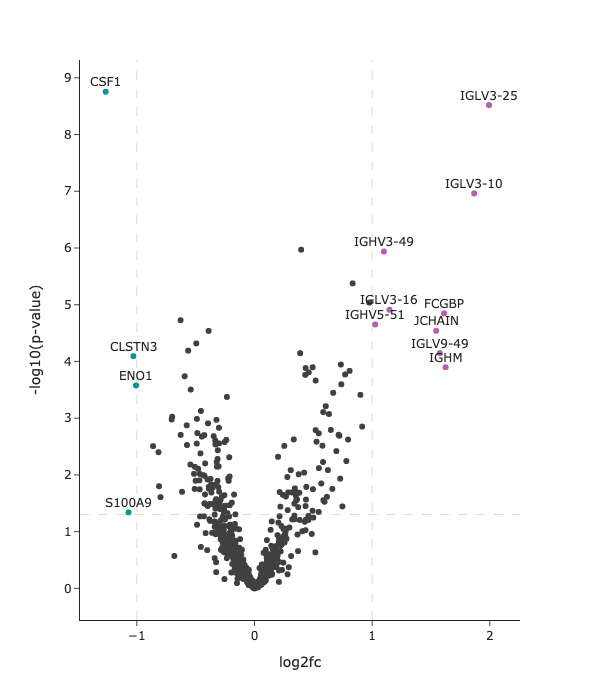

In [70]:
volcano_plot = dataset.plot_volcano(
    column="diagnosis", # column in metadata
    group1="LNB",
    group2="VM",
    labels=True, # add label to significantly enriched proteins
    alpha=0.05 # cutoff for pvalue
)

pio.write_image(volcano_plot, '../submission/f1a.svg', format='svg')

volcano_plot.show(renderer = "png")


Calculating Students t-test...


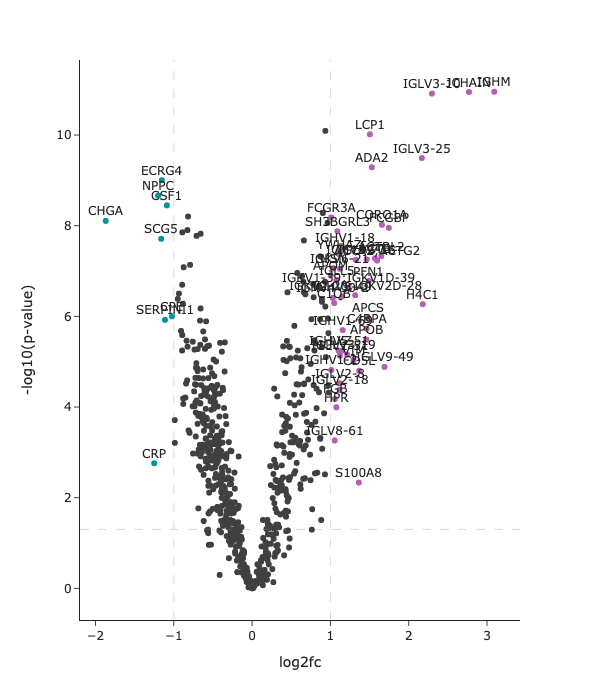

In [71]:
volcano_plot = dataset.plot_volcano(
    column="diagnosis", # column in metadata
    group1="LNB",
    group2="control",
    labels=True, # add label to significantly enriched proteins
    alpha=0.05 # cutoff for pvalue
)

pio.write_image(volcano_plot, '../submission/f1b.svg', format='svg')

volcano_plot.show(renderer = "png")


In [72]:
csf_proteins = df_dev[['Genes']].drop_duplicates()
print(csf_proteins.shape)
csf_proteins['Protein.Group'] = csf_proteins['Genes'].str.split(';')
csf_proteins = csf_proteins.explode('Protein.Group').drop_duplicates()
print(csf_proteins.shape)


(650, 1)
(672, 2)


### Differential expression analysis

In [73]:
# Table to annotate proteins to GO
annotation_table = pd.read_csv('../data/annotation_table.tsv', sep = '\t')

In [74]:
# Differential expression analysis
diffs = []
dfs = []
for groups in [['LNB','VM'],['LNB','control']]:
    print(groups)
    diff_df= dataset.diff_expression_analysis(groups[0],groups[1],column='diagnosis', fdr=0.05)
    diff_df = pd.merge(df_dev[['Genes','Protein.Group']].drop_duplicates(),diff_df, on = 'Protein.Group')
    diff_df.rename(columns={'Protein.Group':'Genes', 'Genes':'Protein.Group'}, inplace=True)
    diff_df = diff_df[(diff_df.pval<0.05)]
    diff_df = pd.merge(diff_df, annotation_test[['Entry','GO','Gene Names']], left_on = 'Protein.Group', right_on = 'Entry', how = 'left')
    diff_df['group1']=groups[0]
    diff_df['group2']=groups[1]
    print(diff_df.shape)
    print('UP: {}'.format(diff_df[(diff_df.log2fc>1)]['Gene Names'].tolist()))
    print('DOWN: {}'.format(diff_df[(diff_df.log2fc<-1)]['Gene Names'].tolist()))
    diff_df = diff_df[(diff_df.log2fc.abs()>1)]
    dfs.append(diff_df)
    print(diff_df.shape)
    diff_df = diff_df['Protein.Group'].tolist()
    print(len(diff_df))
    diffs.append(diff_df)


['LNB', 'VM']
(178, 9)
UP: ['IGLV3-16', 'IGLV3-10', 'IGHV3-49', 'IGLV9-49', 'IGHV5-51', 'JCHAIN IGCJ IGJ', 'IGLV3-25', 'IGHM', 'FCGBP']
DOWN: ['S100A9 CAGB CFAG MRP14', 'ENO1 ENO1L1 MBPB1 MPB1', 'CSF1', 'CLSTN3 CS3 KIAA0726']
(13, 9)
13
['LNB', 'control']
(498, 9)
UP: ['IGLV8-61', 'IGLV2-18', 'IGLV3-16', 'IGLV3-10', 'IGKV2-28; IGKV2-28; IGKV2D-28; IGKV2D-28', 'IGHV4-30-2', 'IGHV3-49', 'IGHV3-73', 'IGLV9-49', 'IGKV6-21', 'IGHV1-18', 'IGHV5-51', 'APOB', 'IGLL5', 'CD5L API6 UNQ203/PRO229', 'APOM G3A NG20 HSPC336', 'HPR', 'JCHAIN IGCJ IGJ', 'IGKV1-39; IGKV1-39; IGKV1D-39; IGKV1D-39', 'IGLV1-51', 'IGLV2-8', 'IGLV3-19', 'IGLV3-25', 'IGHV1-69', 'IGHM', 'FGB', 'APCS PTX2', 'C1QB', 'C4BPA C4BP', 'S100A8 CAGA CFAG MRP8', 'PFN1', 'FCGR3A CD16A FCG3 FCGR3 IGFR3', 'VIM', 'LCP1 PLS2', 'IGHV1-2', 'MSN', 'CORO1A CORO1', 'ACTB', 'LYZ LZM', 'ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA AC

In [75]:
pd.concat([dfs[0], dfs[1]])[['group1', 'group2','Protein.Group', 'Genes', 'pval', 'log2fc', 'GO']].to_excel('../submission/st1.xlsx', index = None)
print(dfs[0]['Protein.Group'].unique().shape)
print(dfs[1]['Protein.Group'].unique().shape)

(13,)
(54,)


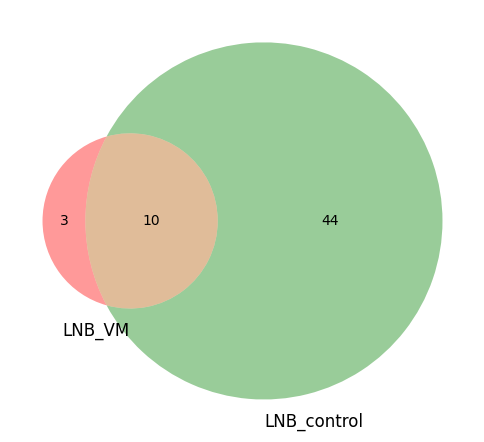

In [76]:
plt.figure(figsize=(6, 6))

# Make the diagram
venn2([set(diffs[0]), set(diffs[1])], set_labels=('LNB_VM','LNB_control'))

#plt.savefig("../output/venn_diagram_csf_dev.svg", format="svg")
plt.show()

### Heatmap

In [77]:
combined_lst = list(set(diffs[0]+diffs[1]))
pd.DataFrame(combined_lst, columns = ['csf_identifiers']).to_csv('../submission/combined_lst.csv', index = None)


In [131]:
info = pd.read_excel('../submission/aps_meta_csf.xlsx')
aps_data = pd.read_table('../submission/aps_data_corrected_csf_development.tsv', sep ='\t').drop(['Protein.Names','Genes','First.Protein.Description'], axis = 1)
aps_data = aps_data.set_index(['Protein.Group']).T.reset_index()
aps_data.rename(columns={'index':'sample_id'}, inplace=True)


(650, 137)
(137, 57)


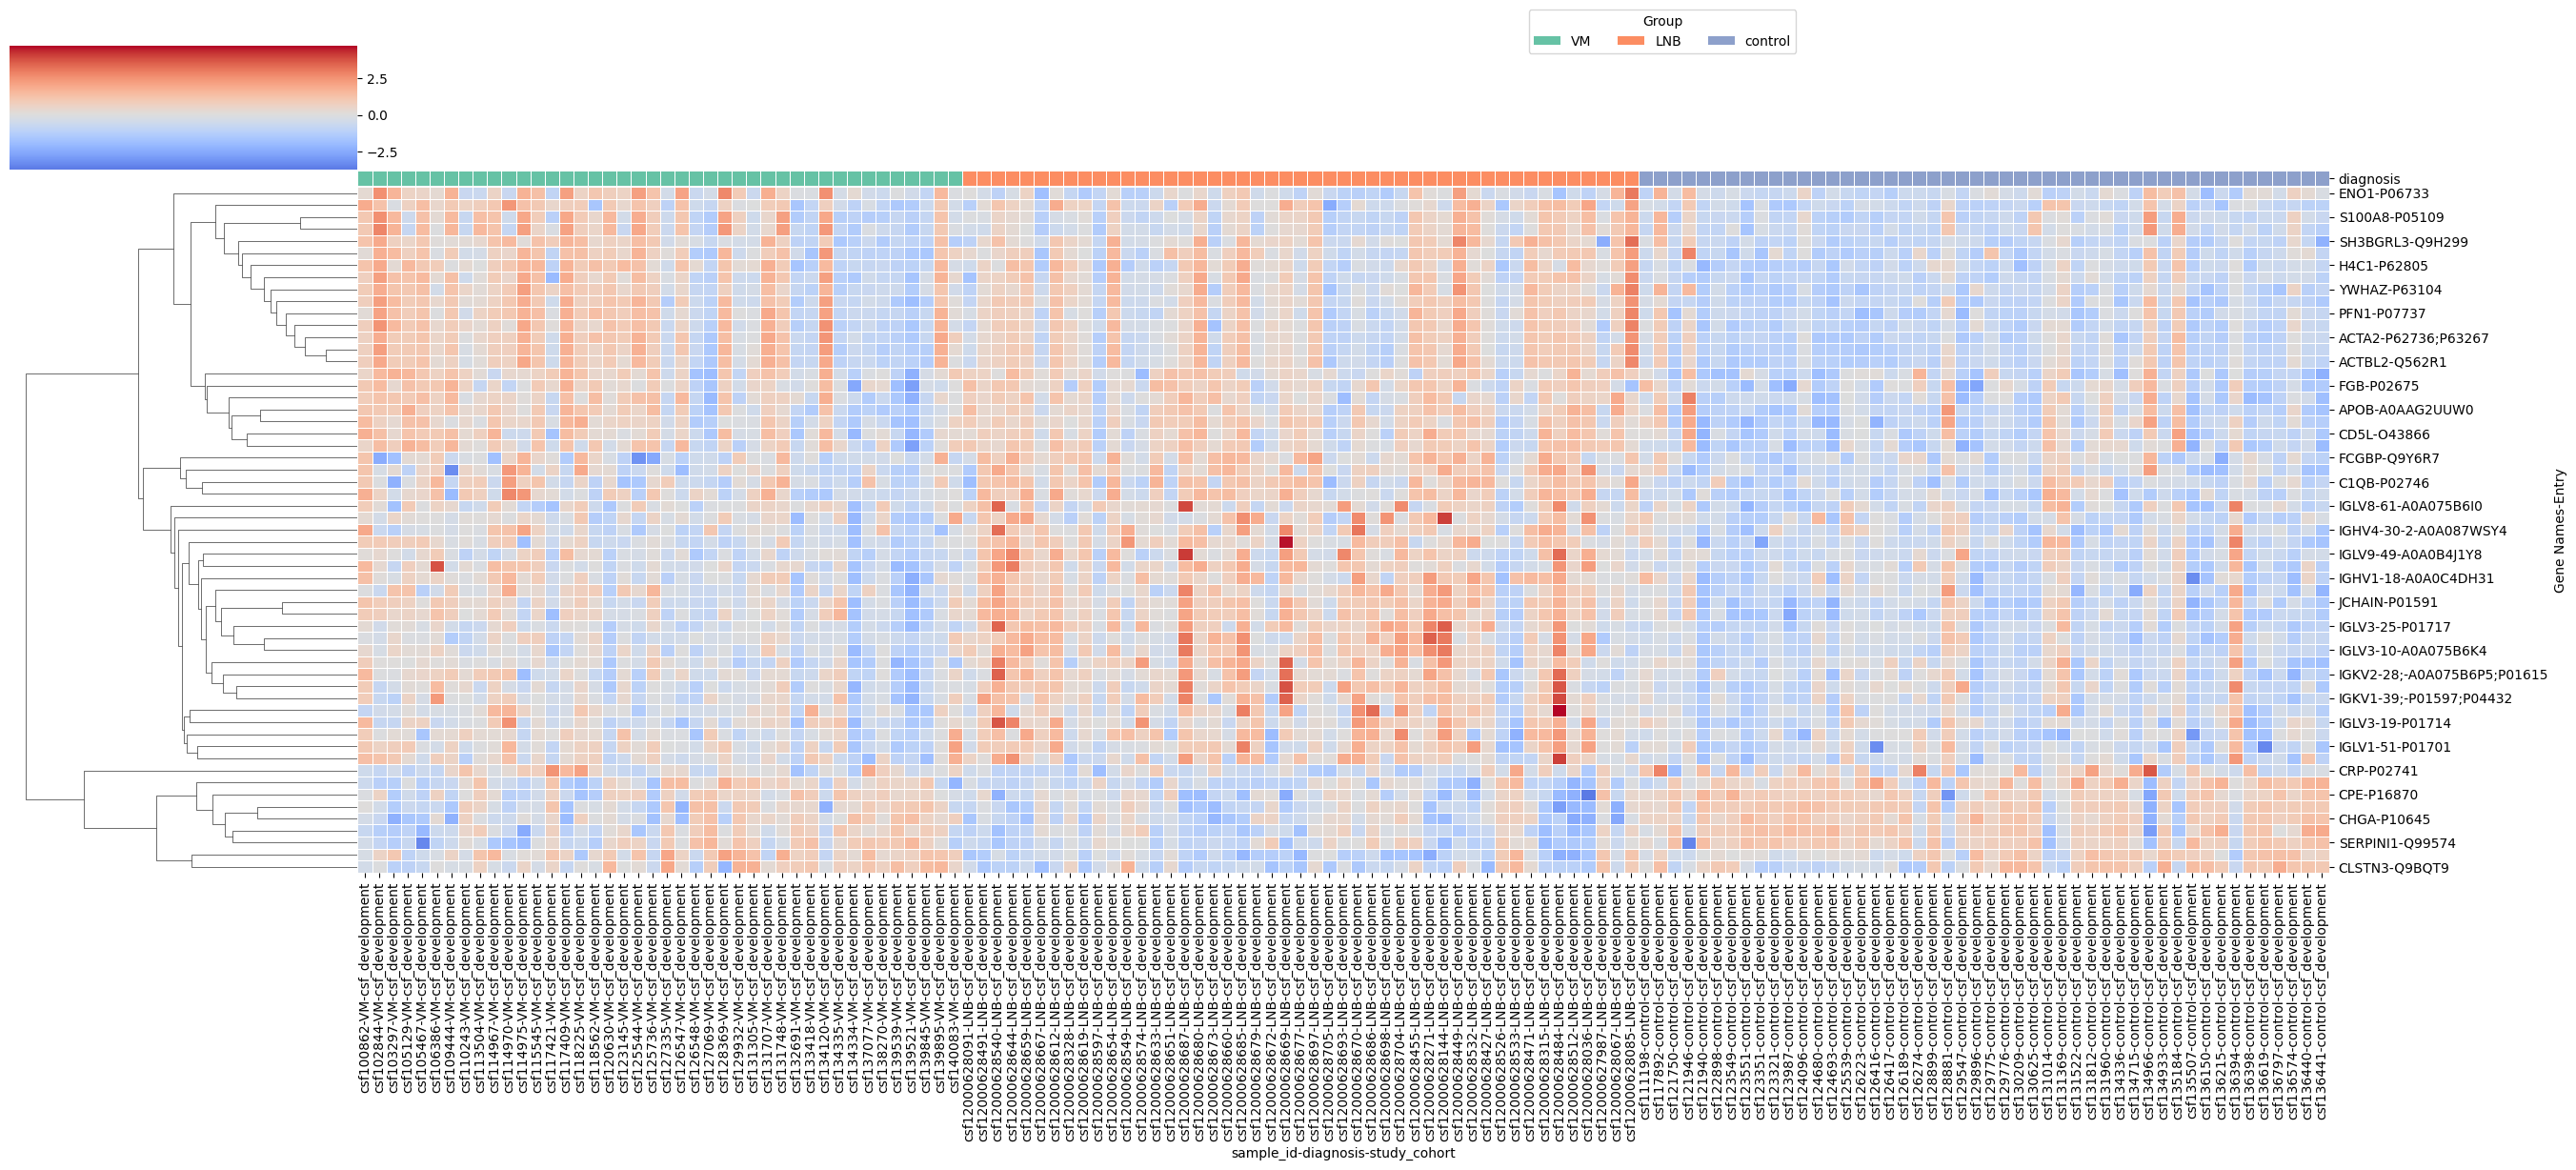

In [ ]:
diagnosis_order = [
    "VM",
    "LNB",
    "control"
]
# Convert diagnosis to categorical with your order
info["diagnosis"] = pd.Categorical(
    info["diagnosis"],
    categories=diagnosis_order,
    ordered=True
)

heatmap_data = np.log2(pd.merge(info.drop('group', axis =1), aps_data, on = 'sample_id')
                       .sort_values(['diagnosis','study_cohort'])
                       .set_index(['sample_id','diagnosis','study_cohort'])
                       .T)
print(heatmap_data.shape)
heatmap_data = heatmap_data.loc[heatmap_data.index.get_level_values(0).isin(combined_lst)].T
print(heatmap_data.shape)
heatmap_data = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()
heatmap_data = heatmap_data.T

# merge annotation with heatmap_data:
annotation_table = pd.merge(pd.DataFrame(heatmap_data.index.tolist(), columns = ['Entry']), annotation_table[['Entry','GO','Gene Names']], on = 'Entry', how = 'left')
annotation_table['Gene Names']=annotation_table['Gene Names'].str.split(' ').str[0]


# 2. Add 'annotation' and 'Gene Names' from annotation_table to the index
annotations = annotation_table['GO'].tolist()  # Replace 'GO' with the correct column name if needed
gene_names = annotation_table['Gene Names'].tolist()  # Ensure 'Gene Names' is the correct column

# Creating a MultiIndex
heatmap_data.index = pd.MultiIndex.from_tuples(
    list(zip(gene_names, heatmap_data.index)),
    names=['Gene Names', 'Entry']
)

# grouping colors
group_labels = heatmap_data.columns.get_level_values("diagnosis").astype(str)
group_pal = sns.color_palette('Set2',group_labels.unique().size)
group_lut = dict(zip(map(str, group_labels.unique()), group_pal))
# create group index
group_colors = pd.Series(group_labels, index=heatmap_data.columns).map(group_lut)

g1 = sns.clustermap(heatmap_data, z_score=False, col_cluster=False,
                   figsize=(35,12), col_colors = group_colors, #row_colors = annotation_colors, 
                   linewidth=0.5, cmap = "coolwarm", center = 0,
                   dendrogram_ratio=0.15, metric = 'euclidean', colors_ratio=0.018)

# add legends
for label in group_labels.unique():
    g1.ax_col_dendrogram.bar(0, 0, color=group_lut[label], label=label, linewidth=0);
l1 = g1.ax_col_dendrogram.legend(title='Group', loc="center", ncol=7, bbox_to_anchor=(0.5, 1), bbox_transform=gcf().transFigure)
g1.fig.subplots_adjust(right=0.7)

g1.figure.savefig("../submission/f1c.svg")

In [103]:
row_linkage_dev = g1.dendrogram_row.linkage

### Sankey plot with GO groups of the heatmap proteins

In [80]:
heatmap_order = heatmap_data.iloc[g1.dendrogram_row.reordered_ind].index.get_level_values("Entry").tolist()

In [81]:
sankey_df = pd.merge(pd.DataFrame(heatmap_data.index.get_level_values("Entry").tolist(), columns = ['Entry']), annotation_table[['Entry','GO','Gene Names']].drop_duplicates(), on = 'Entry', how = 'left')
sankey_df.fillna('nan', inplace = True)
# sort the df according to heatmap
sankey_df['Entry'] = pd.Categorical(sankey_df['Entry'], categories=heatmap_order, ordered=True)
sankey_df = sankey_df.sort_values(['Entry'])
# format the df
sankey_df.Entry = sankey_df.Entry.astype(str)
sankey_df['Gene Names'] = sankey_df['Gene Names'].str.split(' ', expand = True)[0] 

In [82]:
import plotly.graph_objects as go
import random
import plotly.io as pio

# Data for Sankey plot

# Get unique values of Genes and annotations
all_Genes = list(sankey_df['Gene Names'].unique())
#all_Genes.reverse()
all_annotations = list(sankey_df['GO'].unique())


# Create indices for sankey source (Gene Namess) and targets (annotations)
sankey_df['Gene Names_index'] = sankey_df['Gene Names'].apply(lambda x: all_Genes.index(x))
sankey_df = sankey_df.sort_values(by='Gene Names_index').reset_index(drop=True)  # Ensure sankey_df is sorted by the order of 'all_Genes'
sankey_df['annotation_index'] = sankey_df['GO'].apply(lambda x: len(all_Genes) + all_annotations.index(x))

# Generate a color for each annotation
colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(all_annotations))]

# Map annotation index to colors
target_colors = {len(all_Genes) + i: colors[i] for i in range(len(all_annotations))}

# Create a list of colors for the links based on target node
link_colors = [target_colors[target] for target in sankey_df['annotation_index']]

# Define node positions for source nodes (x = 0.1 for all sources, y spaced evenly)
source_y_positions = [i / len(all_Genes) for i in range(len(all_Genes))]  # Evenly spaced source y positions
source_x_positions = [0.1] * len(all_Genes)  # Fixed x position for sources

# Only set positions for sources, leave target positions to be automatically placed
node_x_positions = source_x_positions + [None] * len(all_annotations)  # No x positions for targets
node_y_positions = source_y_positions + [None] * len(all_annotations)  # No y positions for targets

# Create Sankey diagram
fig = go.Figure(go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = all_Genes + all_annotations,
        x = node_x_positions,
        y = node_y_positions
    ),
    link = dict(
        source = sankey_df['Gene Names_index'],  # starting points (Gene Namess)
        target = sankey_df['annotation_index'],  # end points (annotations)
        value = [1] * len(sankey_df),  # each link has equal value (1 for each protein-GO link)
        color = link_colors  # set the color of links
    )
))

# Update layout and display the figure
fig.update_layout(title_text="Sankey Diagram of Protein Gene Names and Annotations", 
                  font_size=10,
                  height=800,
                  width=600)

# Define the path where you want to save the PDF
output_path = '../submission/f1c_sankey.svg'

# Save the figure 
pio.write_image(fig, output_path, format='svg')

fig.show()

### CSF Validation

In [83]:
loader = alphastats.DIANNLoader(file = "../submission/aps_data_corrected_csf_validation_nameswap.tsv")
dataset = alphastats.DataSet(
    loader = loader, 
    metadata_path="../submission/aps_meta_csf.xlsx", 
    sample_column="sample_id"
)
dataset.preprocess(
    log2_transform=True,
    remove_contaminations=True
)

DataSet has been created.
Attributes of the DataSet can be accessed using: 
DataSet.rawinput:	 Raw Protein data.
DataSet.mat:		Processed data matrix with ProteinIDs/ProteinGroups as columns and samples as rows. All computations are performed on this matrix.
DataSet.metadata:	Metadata for the samples in the matrix. Metadata will be matched with DataSet.mat when needed (for instance Volcano Plot).
Data has been log2-transformed.


Calculating Students t-test...


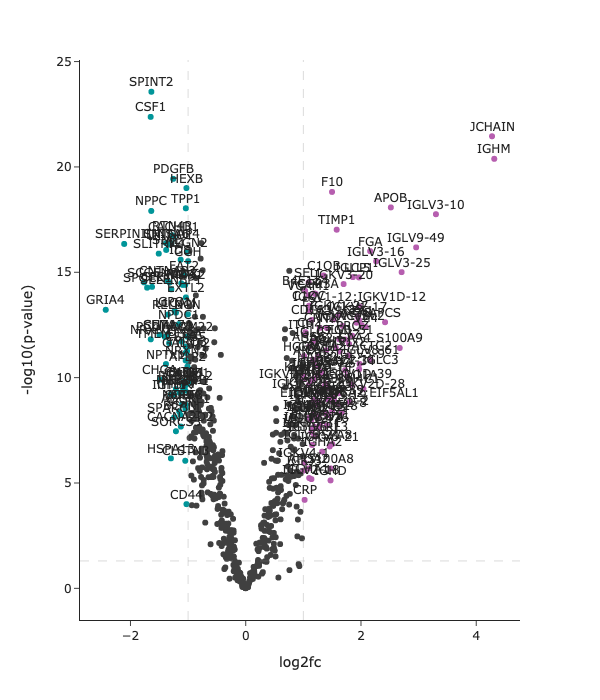

In [84]:
volcano_plot = dataset.plot_volcano(
    column="diagnosis", # column in metadata
    group1="LNB",
    group2="control",
    labels=True, # add label to significantly enriched proteins
    alpha=0.05 # cutoff for pvalue
)

pio.write_image(volcano_plot, '../submission/s2.svg', format='svg')

volcano_plot.show(renderer = "png")

Calculating Students t-test...


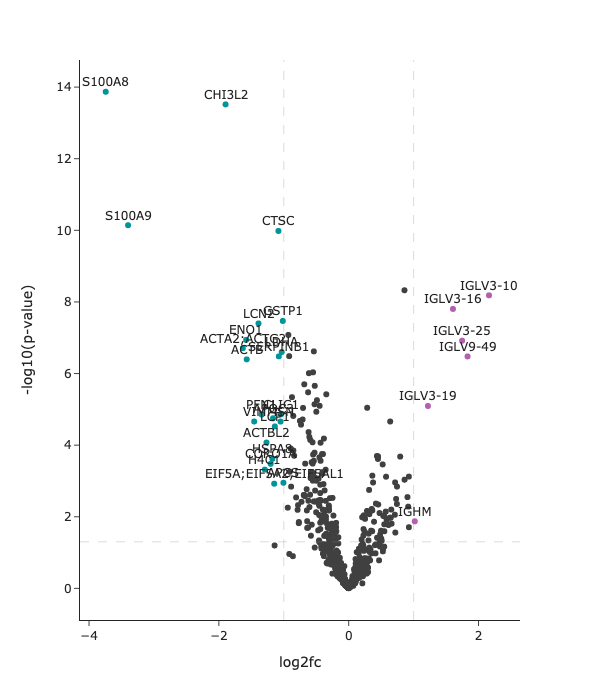

In [85]:
volcano_plot = dataset.plot_volcano(
    column="diagnosis", # column in metadata
    group1="LNB",
    group2="VM",
    labels=True, # add label to significantly enriched proteins
    alpha=0.05 # cutoff for pvalue
)

pio.write_image(volcano_plot, '../submission/s3.svg', format='svg')

volcano_plot.show(renderer = "png")

In [92]:
diffs = []
for groups in [['LNB','VM'],['LNB','control']]:
    print(groups)
    diff_df= dataset.diff_expression_analysis(groups[0],groups[1],column='diagnosis', fdr=0.05)
    diff_df = pd.merge(df_val[['Genes','Protein.Group']].drop_duplicates(),diff_df, on = 'Protein.Group')
    diff_df.rename(columns={'Protein.Group':'Genes', 'Genes':'Protein.Group'}, inplace=True)
    diff_df = diff_df[(diff_df.pval<0.05)]
    #diff_df = pd.merge(diff_df, annotation_table[['Entry','GO','Gene Names']], left_on = 'Protein.Group', right_on = 'Entry', how = 'left')

    print(diff_df.shape)
    print('UP: {}'.format(diff_df[(diff_df.log2fc>1)]['Genes'].tolist()))
    print('DOWN: {}'.format(diff_df[(diff_df.log2fc<-1)]['Genes'].tolist()))
    diff_df = diff_df[(diff_df.log2fc.abs()>1)]['Protein.Group'].tolist()
    print(len(diff_df))
    diffs.append(diff_df)
combined_lst_val = list(set(diffs[0]+diffs[1]))
print(len(combined_lst_val))

['LNB', 'VM']
(234, 4)
UP: ['IGLV3-16', 'IGLV3-10', 'IGLV9-49', 'IGLV3-19', 'IGLV3-25', 'IGHM']
DOWN: ['CLIC1', 'LDHA', 'APOC3', 'APCS', 'S100A8', 'S100A9', 'ENO1', 'PFN1', 'VIM', 'GSTP1', 'HSPA8', 'LCP1', 'MSN', 'SERPINB1', 'CORO1A', 'CTSC', 'ACTB', 'ACTA2;ACTG2', 'H4C1', 'EIF5A;EIF5A2;EIF5AL1', 'LCN2', 'CHI3L2', 'ACTBL2']
29
['LNB', 'control']
(579, 4)
UP: ['IGKV3-7', 'IGLV8-61', 'IGLV7-46', 'IGLV2-18', 'IGLV3-16', 'IGLV3-10', 'IGLV3-9', 'IGKV2-28;IGKV2D-28', 'IGKV2D-29', 'IGKV1-27', 'IGHV4-30-2', 'SAA2-SAA4', 'IGKJ3', 'IGKJ5', 'IGHV6-1', 'IGHV3-15', 'IGHV2-26', 'IGHV3-73', 'IGHV3-74', 'IGLV9-49', 'IGKV6-21', 'IGHV1-18', 'IGHV5-51', 'IGKV1-12;IGKV1D-12', 'IGHV3-72', 'IGHG3', 'IGKV1-33', 'APOB', 'IGLC7', 'B4E1Z4', 'IGLL5', 'CLIC1', 'CD5L', 'F2', 'HP', 'HPR', 'F9', 'F10', 'TIMP1', 'JCHAIN', 'IGKV1-39;IGKV1D-39', 'IGKV1-17', 'IGKV1-5', 'IGKV3-20', 'IGLV1-47', 'IGLV1-51', 'IGLV2-8', 'IGLV3-19', 'IGLV3-25', 'IGHV1-69', 'IGHV3-7', 'IGHV4-39', 'IGKC', 'IGHM', 'IGHA1', 'IGHA2', 'IGHD', 'FGA'

### Comparison between validation and development

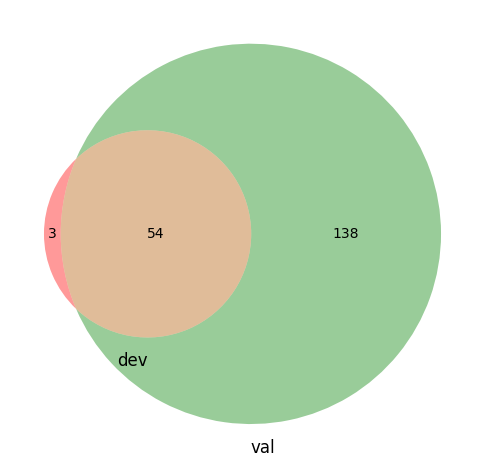

In [ ]:
# Comparison to Development Cohort

plt.figure(figsize=(6, 6))

# Make the diagram
venn2([set(combined_lst), set(combined_lst_val)], set_labels=('dev','val'))

#plt.savefig("../output/venn_diagram_csf_val_dev.svg", format="svg")
plt.show()


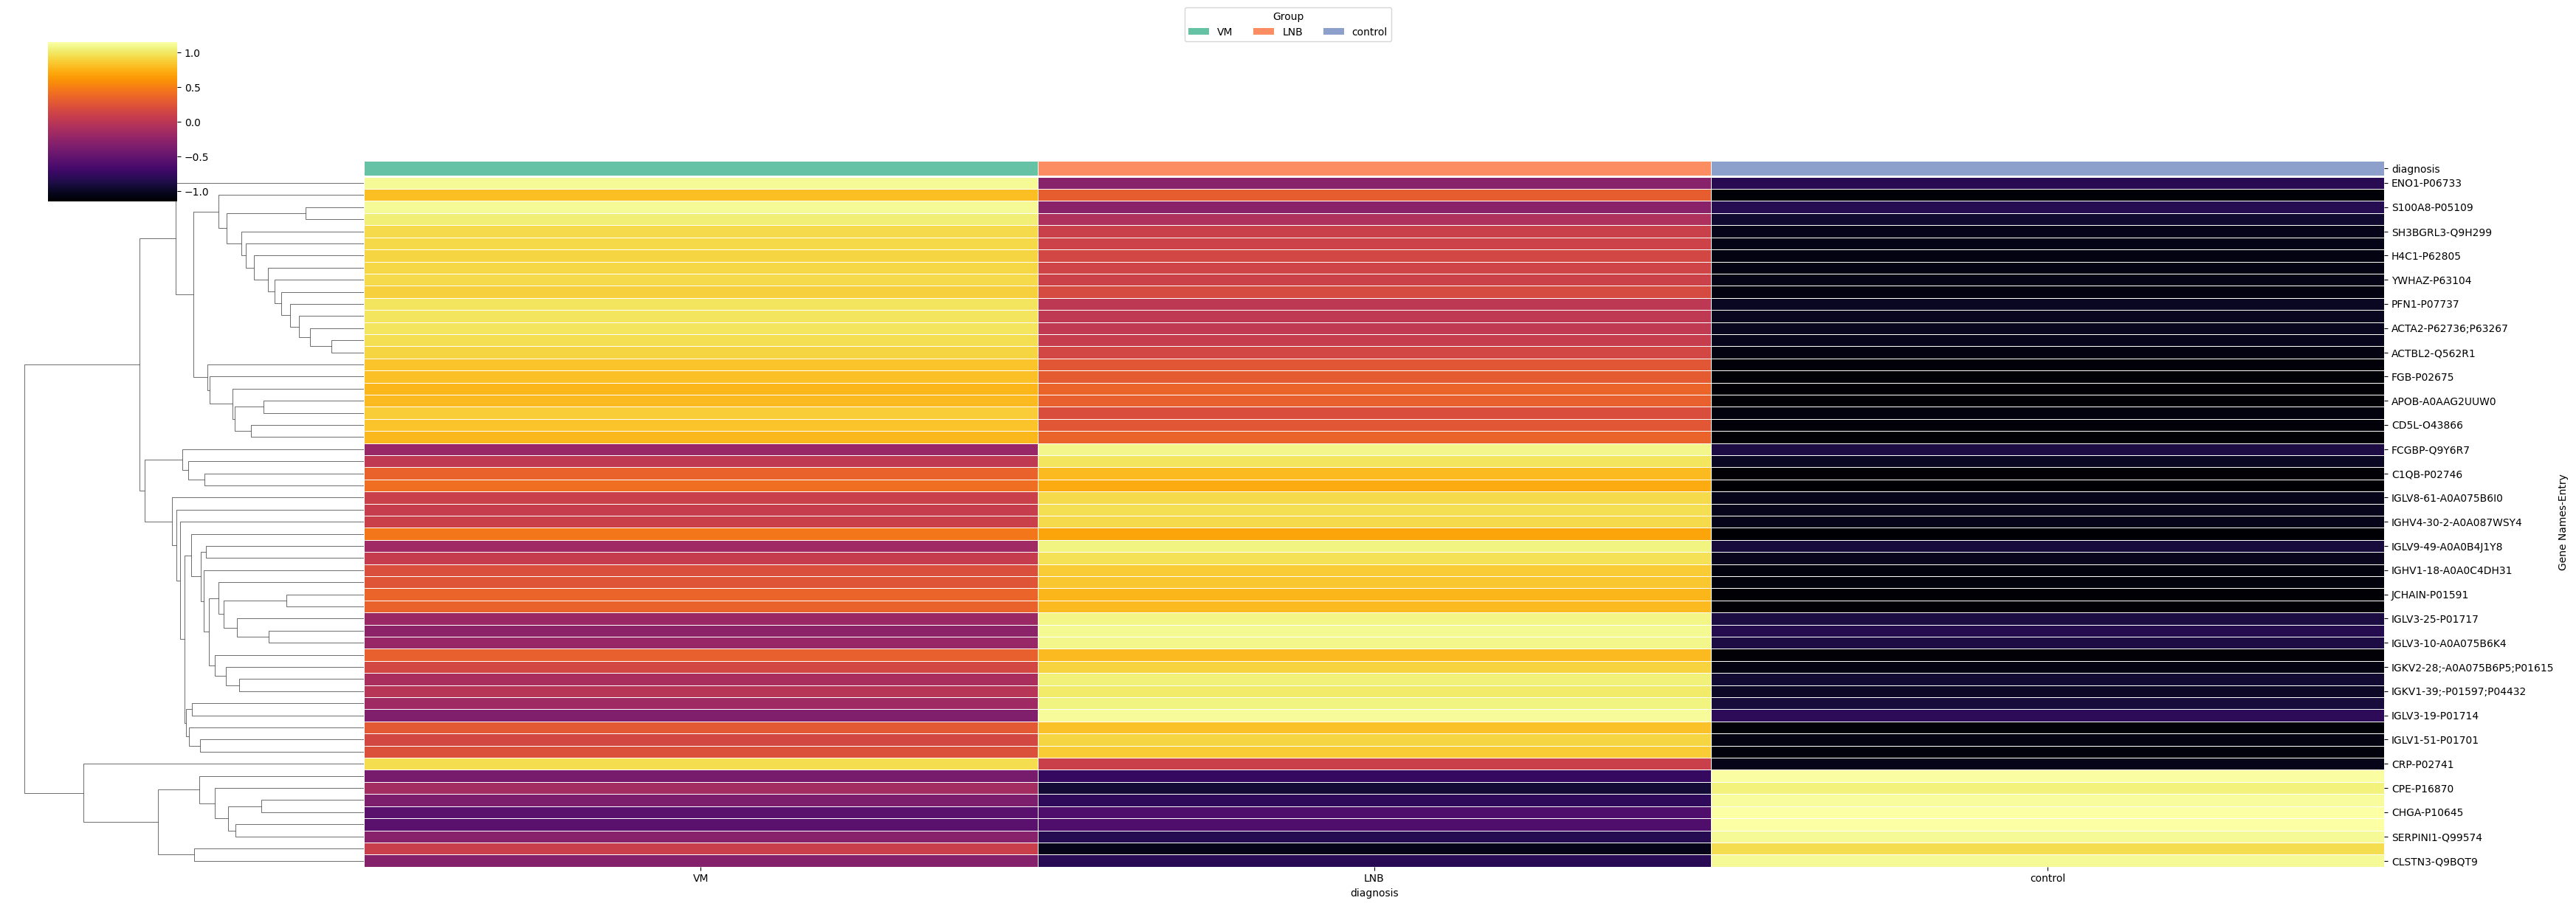

In [116]:
# Validation Heatmap
info = pd.read_excel('../submission/aps_meta_csf.xlsx')
aps_data = pd.read_table('../submission/aps_data_corrected_csf_validation.tsv', sep ='\t').drop(['Protein.Names','Genes','First.Protein.Description'], axis = 1)
aps_data = aps_data.set_index(['Protein.Group']).T.reset_index()
aps_data.rename(columns={'index':'sample_id'}, inplace=True)

diagnosis_order = [
    "VM",
    "LNB",
    "control"
]
# Convert diagnosis to categorical with your order
info["diagnosis"] = pd.Categorical(
    info["diagnosis"],
    categories=diagnosis_order,
    ordered=True
)

heatmap_data = np.log2(pd.merge(info.drop('group', axis =1), aps_data, on = 'sample_id')
                       .set_index(['sample_id','diagnosis','study_cohort'])
                       .T)
heatmap_data = heatmap_data.loc[heatmap_data.index.get_level_values(0).isin(combined_lst)].T
heatmap_data = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()
heatmap_data = heatmap_data.T

# Compute the mean
mean_df = heatmap_data.T
heatmap_data = mean_df.groupby(mean_df.index.get_level_values('diagnosis')).mean().reset_index()
heatmap_data = heatmap_data.sort_values(['diagnosis']).set_index(['diagnosis']).T


# merge annotation with heatmap_data:
annotation_table = pd.merge(pd.DataFrame(heatmap_data.index.tolist(), columns = ['Entry']), annotation_table[['Entry','GO','Gene Names']].drop_duplicates(), on = 'Entry', how = 'left')
annotation_table['Gene Names']=annotation_table['Gene Names'].str.split(' ').str[0]


# 2. Add 'annotation' and 'Gene Names' from annotation_table to the index
annotations = annotation_table['GO'].tolist()  # Replace 'GO' with the correct column name if needed
gene_names = annotation_table['Gene Names'].tolist()  # Ensure 'Gene Names' is the correct column

# Creating a MultiIndex
heatmap_data.index = pd.MultiIndex.from_tuples(
    list(zip(gene_names, heatmap_data.index)),
    names=['Gene Names', 'Entry']
)

# grouping colors
group_labels = heatmap_data.columns.get_level_values("diagnosis").astype(str)
group_pal = sns.color_palette('Set2',group_labels.unique().size)
group_lut = dict(zip(map(str, group_labels.unique()), group_pal))
# create group index
group_colors = pd.Series(group_labels, index=heatmap_data.columns).map(group_lut)

g = sns.clustermap(heatmap_data, z_score=False, col_cluster=False,
                   row_linkage=row_linkage_dev,  # Use row_linkage to cluster rows
                   figsize=(35,12), col_colors=group_colors, 
                   linewidth=0.5, cmap="inferno", center=0,
                   dendrogram_ratio=0.15, metric='euclidean', colors_ratio=0.018)

# add legends
for label in group_labels.unique():
    g.ax_col_dendrogram.bar(0, 0, color=group_lut[label], label=label, linewidth=0);
l1 = g.ax_col_dendrogram.legend(title='Group', loc="center", ncol=7, bbox_to_anchor=(0.5, 1), bbox_transform=gcf().transFigure)

g1.figure.savefig("../submission/f1c_val.svg")

<!-- # ML analysis -->

## Diagnostic Machine Learning Classification: LNB vs. control

### Strategy:
1) subset ML input to LNB and Control
2) Run nested cross-validation to: 1) select optimal hyperparameters and features 2) select optimal algorithm
3) After finishing model development, test performance on the validation cohort

In [233]:
# Load ML data
ml_data = pd.read_csv("../submission/aps_data_corrected_csf_combined.tsv", sep = '\t')
ml_data = ml_data.set_index(['Protein.Group']).drop(['Protein.Names','Genes','First.Protein.Description'], axis = 1).T.reset_index()
ml_data.rename(columns={'index':'sample_id'}, inplace=True)

ml_data = np.log2(pd.merge(info,#.replace({'study_cohort':{'csf_development':'csf_validation', 'csf_validation':'csf_development'}}), 
                           ml_data, on = 'sample_id')
                       .sort_values(['diagnosis','study_cohort'])
                       .set_index(['sample_id','diagnosis','study_cohort']).astype(float))
ml_data.head()

A0A024R6N5  A0A075B6H7  A0A075B6I0  \
sample_id      diagnosis study_cohort                                          
csf12000628091 LNB       csf_development      27.947      28.865      25.703   
csf12000628491 LNB       csf_development      23.408      29.207      26.649   
csf12000628540 LNB       csf_development      28.389      30.196      29.570   
csf12000628644 LNB       csf_development      26.018      30.175      24.536   
csf12000628659 LNB       csf_development      31.128      29.809      26.392   

                                          A0A075B6I9  A0A075B6J9  A0A075B6K0  \
sample_id      diagnosis study_cohort                                          
csf12000628091 LNB       csf_development      26.429      22.344      25.074   
csf12000628491 LNB       csf_development      26.467      24.022      25.361   
csf12000628540 LNB       csf_development      28.651      25.140      25.596   
csf12000628644 LNB       csf_development      27.586      22.558      26.442   
csf12000628659 LNB       csf_development      26.998      23.532      26.912   

                                          A0A075B6K4  A0A075B6K5  \
sample_id      diagnosis study_cohort                              
csf12000628091 LNB       csf_development      26.427      26.074   
csf12000628491 LNB       csf_development      25.127      26.393   
csf12000628540 LNB       csf_development      27.888      26.694   
csf12000628644 LNB       csf_development      27.279      28.981   
csf12000628659 LNB       csf_development      28.540      26.720   

                                          A0A075B6P5;P01615  \
sample_id      diagnosis study_cohort                         
csf12000628091 LNB       csf_development             26.529   
csf12000628491 LNB       csf_development             26.989   
csf12000628540 LNB       csf_development             31.481   
csf12000628644 LNB       csf_development             28.517   
csf12000628659 LNB       csf_development             29.216   

                                          A0A075B6R9;A0A0C4DH68  ...  Q9Y2T3  \
sample_id      diagnosis study_cohort                            ...           
csf12000628091 LNB       csf_development                 26.096  ...  21.606   
csf12000628491 LNB       csf_development                 26.255  ...  21.235   
csf12000628540 LNB       csf_development                 26.070  ...  21.877   
csf12000628644 LNB       csf_development                 24.864  ...  21.943   
csf12000628659 LNB       csf_development                 24.083  ...  21.519   

                                          Q9Y4C0  Q9Y4L1  Q9Y5I4  Q9Y5Y7  \
sample_id      diagnosis study_cohort                                      
csf12000628091 LNB       csf_development  23.080  22.048  20.313  22.987   
csf12000628491 LNB       csf_development  24.932  22.626  20.815  23.483   
csf12000628540 LNB       csf_development  23.145  21.897  19.613  23.041   
csf12000628644 LNB       csf_development  23.909  22.503  19.541  23.411   
csf12000628659 LNB       csf_development  23.832  21.902  19.667  22.797   

                                          Q9Y646  Q9Y6N7  Q9Y6R7  V9GYM3  \
sample_id      diagnosis study_cohort                                      
csf12000628091 LNB       csf_development  23.267  21.174  22.929  29.152   
csf12000628491 LNB       csf_development  24.523  21.890  25.910  30.366   
csf12000628540 LNB       csf_development  22.221  21.373  24.696  27.299   
csf12000628644 LNB       csf_development  24.036  21.504  26.546  31.553   
csf12000628659 LNB       csf_development  23.553  21.282  25.110  25.854   

                                          X6RKN2  
sample_id      diagnosis study_cohort             
csf12000628091 LNB       csf_development  22.775  
csf12000628491 LNB       csf_development  24.014  
csf12000628540 LNB       csf_development  22.065  
csf12000628644 LNB       csf_development  23.417  
csf12000628659 LNB       csf_development  23.180  

[5 rows x 650 co

In [234]:
# subset data to the significant findings
ml_data = ml_data[combined_lst]
ml_data.index.set_names(['_sample','_diagnosis','_study'], inplace = True)
print(ml_data.index.get_level_values('_study').value_counts())
# change column names to gene names
gene_mapping_df = uniprot_mapping[uniprot_mapping.Entry.isin(combined_lst)][['Entry','Gene Names']].drop_duplicates()
gene_mapping_df['Gene Names']=gene_mapping_df['Gene Names'].str.split(' ').str[0].str.split(';').str[0]
gene_mapping_df.set_index('Entry', inplace = True)

ml_data.columns = gene_mapping_df.loc[combined_lst]['Gene Names'].tolist()
ml_data.to_csv('../submission/csf_ml_data.tsv', sep = '\t')


_study
csf_validation    155
csf_development   137
Name: count, dtype: int64


In [235]:
# Prepare sklearn models and grids
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve
from scipy import interp
import plotly.graph_objects as go


from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from scipy.stats import zscore


import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import ensemble
from sklearn.linear_model import Perceptron

from scipy.stats import uniform, truncnorm, randint

import time

n_features = len(combined_lst)
n_samples = int(ml_data.loc[ml_data.index.get_level_values('_study') == 'csf_development'].shape[0]*0.8)


# hyperparameter grids
lr_grid = {"C": [0.1, 0.5, 1],#np.logspace(0, 4, num=10),
           "penalty": ['l1', 'l2','elasticnet'],
           "solver": ['liblinear', 'saga'],
           "max_iter":[5000]}
lda_grid = {"solver": ['svd', 'lsqr', 'eigen'],
            "shrinkage":[None, 'auto']}
knn_grid = {"n_neighbors": randint(1,11),
            "weights":['uniform','distance'], 
            "algorithm":['auto','ball_tree','kd_tree','brute'], 
            "leaf_size":randint(10,50), 
            "p":[1,2],
            "metric":['euclidean','minkowski','mahalanobis','seuclidean']}
dt_grid = {"criterion": ["gini", "entropy"],
            "splitter": ['best','random'],
            #"max_features": randint(1, n_features),
            "min_samples_leaf": randint(1, 11),
            "class_weight":[None, 'balanced']}
nb_grid = {}
svc_grid = {"kernel": ['linear'], #'poly', 'rbf', 'sigmoid'], #removed because it does not work with importance getter
            "gamma":['scale','auto'],
            "class_weight" : ['balanced',None],
            "probability" : [True]}
rf_grid = {"max_depth": [3, None],
            "min_samples_split": randint(1, 11),
            "min_samples_leaf": randint(1, 11),
            "bootstrap": [True, False],
            "criterion": ["gini", "entropy"],
            "n_estimators": randint(1,200),
            "max_features": truncnorm(a=0, b=1, loc=0.25, scale=0.1)}
nnet_grid = {"hidden_layer_sizes":randint(1,n_features),
            "activation": ['identity','logistic','tanh','relu'],
            "solver":['lbfgs','sgd','adam'],
            "batch_size":[int(n_samples/10),int(n_samples/5), int(n_samples/2)],
            "learning_rate_init":np.logspace(np.log10(0.00001), np.log10(0.99999), num=10),
            "max_iter":[5000],
            "early_stopping":[True],
            "validation_fraction":[0.25]}
perceptron_grid = {"penalty": ['l1', 'l2','elasticnet'],
                   "max_iter":[5000],
                   "class_weight" : ['balanced',None]}
                   
gp_grid = {}
ab_grid = {}
qda_grid = {}
eet_grid = {}

# models
models = []
models.append(('LR', lr_grid, LogisticRegression(random_state=7)))
models.append(('LDA', lda_grid, LinearDiscriminantAnalysis()))
models.append(('KNN', knn_grid, KNeighborsClassifier()))
models.append(('DT', dt_grid, DecisionTreeClassifier(random_state=7)))
models.append(('Naive Bayes', nb_grid, GaussianNB()))
models.append(('SVC', svc_grid, SVC(random_state=7)))
models.append(('RF', rf_grid, RandomForestClassifier(random_state=7)))
models.append(('NNet', nnet_grid, MLPClassifier(random_state=7)))
models.append(('GP', gp_grid, GaussianProcessClassifier(random_state=7)))
models.append(('Adaboost', ab_grid, AdaBoostClassifier(random_state=7)))
models.append(('QDA', qda_grid, QuadraticDiscriminantAnalysis()))
models.append(('ensembleextratree', eet_grid, ensemble.ExtraTreesClassifier(random_state=7)))


In [236]:
# prepare ML data by zscoring and formatting
prepared_data = ml_data.copy()
prepared_data=zscore(prepared_data, axis = 1)
train_data = prepared_data.loc[(prepared_data.index.get_level_values('_study')=='csf_development')&(prepared_data.index.get_level_values('_diagnosis').isin(['LNB','VM']))]

no_cv = 5
X = train_data.values # all the protein columns
sample_lst = train_data.index.get_level_values('_sample').values
y = pd.Categorical(train_data.index.get_level_values('_diagnosis')).codes # LNB 0 and VM 1

X_train = X.copy()
y_train = y.copy()
sum(y_train)


42

In [237]:
val_data = prepared_data.loc[(prepared_data.index.get_level_values('_study')=='csf_validation')&(prepared_data.index.get_level_values('_diagnosis').isin(['LNB','VM']))]
X_val = val_data.values
y_val = pd.Categorical(val_data.index.get_level_values('_diagnosis')).codes
sum(y_val)

41

In [238]:
# Run nested cross-validation on development data

from itertools import compress
protein_cols = gene_mapping_df.loc[combined_lst]['Gene Names'].tolist()
# ML alg. selection
optimal_models = []
optimal_no_features = []
optimal_features = []
start_time = time.time()

dfs = []
metrics = []
to_plot = []   
fitted_models = []
    
for name, grid, estimator in models:
    print(name)
    # grid search
    selector = RandomizedSearchCV(estimator=estimator, param_distributions=grid, cv=StratifiedKFold(no_cv), scoring = 'f1_weighted', n_jobs = -1)
    clf = selector.fit(X_train,y_train)
    optimal_model = clf.best_estimator_
    optimal_models.append(optimal_model)
    # feature reduction
    if name in ['Naive Bayes','NNet', 'GP', 'QDA', 'KNN']: # skip rfecv for models not supported by importance
        optimal_no_features.append(len(protein_cols))
        optimal_features.append(protein_cols)
        print('skipping feature importance')
        X_reduced = X_train
        X_val_reduced = X_val
    else:
        selector = RFECV(optimal_model, cv=5, scoring='f1_weighted')
        selector = selector.fit(X_train, y_train)
        optimal_no_features.append(sum(selector.support_))
        optimal_features.append(list(compress(protein_cols, selector.support_)))
        print('optimal no features = {}'.format(sum(selector.support_)))
        X_reduced = X_train[:,selector.support_]
        X_val_reduced = X_val[:, selector.support_]
    
    # compute cv results
    print('computing predictions for: {}'.format(name))
    classifier = optimal_model
    mccs = []
    aucs = []
    fits = []
    mcc_val = []
    auc_val = []
                            
    # calculate performance during training
    cv = StratifiedKFold(n_splits=no_cv)
    for i, (train, test) in enumerate(cv.split(X_reduced, y_train)):
        print('cv: {}'.format(i+1))
        classifier.fit(X_reduced[train], y_train[train])
        
        fits.append(classifier)
        # predict for "test" set
        y_pred = classifier.predict(X_reduced[test])
        y_prob = classifier.predict_proba(X_reduced[test])[:,1]
        result = pd.DataFrame([y_train[test], y_pred, y_prob]).T
        result.columns = ['observed','predicted','probability']
        result['cv']=i+1
        result['model']=name
        result['sample']=sample_lst[test]
        result['run']='test'
        dfs.append(result)
        mccs.append(round(matthews_corrcoef(result.observed, result.predicted),2))
        aucs.append(round(roc_auc_score(result.observed,result.probability),2))
        # predict for validation sets
        y_pred = classifier.predict(X_val_reduced)
        y_prob = classifier.predict_proba(X_val_reduced)[:,1]
        result = pd.DataFrame([y_val, y_pred, y_prob]).T
        result.columns = ['observed','predicted','probability']
        result['cv']=i+1
        result['model']=name
        result['sample']=val_data.index.get_level_values('_sample').tolist()
        result['run']='val'
        dfs.append(result)  
        mcc_val.append(round(matthews_corrcoef(result.observed, result.predicted),2))
        auc_val.append(round(roc_auc_score(result.observed,result.probability),2))      
        
    fitted_models.append(fits)
    #test
    metrics_results = pd.DataFrame(mccs)
    metrics_results.columns = ['MCC']
    metrics_results['AUROC']=aucs
    metrics_results['cv']=list(range(1,1+no_cv))
    metrics_results['model']=name
    metrics_results['run']='test'
    metrics.append(metrics_results)

    #val
    metrics_results = pd.DataFrame(mccs)
    metrics_results.columns = ['MCC']
    metrics_results['AUROC']=aucs
    metrics_results['cv']=list(range(1,1+no_cv))
    metrics_results['model']=name
    metrics_results['run']='val'
    metrics.append(metrics_results)
    
    mcc_mean = np.mean(mccs)
    mcc_std = np.std(mccs)
    auroc_mean = np.mean(aucs)
    auroc_std = np.std(aucs)
    to_plot.append([name, mcc_mean, mcc_std, auroc_mean, auroc_std])
    print('MCC: {}, AUROC: {}'.format(mcc_mean, auroc_mean))
    
    print('\n{} model tested --- {} minutes ---\n'.format(name,round(((time.time() - start_time)/60),3)))


result_df = pd.concat(dfs)
metrics_df = pd.concat(metrics)


LR


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/U

optimal no features = 15
computing predictions for: LR
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.716, AUROC: 0.908

LR model tested --- 0.033 minutes ---

LDA


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.

/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


7 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estima

optimal no features = 19
computing predictions for: LDA
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.708, AUROC: 0.922

LDA model tested --- 0.042 minutes ---

KNN
skipping feature importance
computing predictions for: KNN
cv: 1
cv: 2


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
  

cv: 3
cv: 4
cv: 5
MCC: 0.6, AUROC: 0.808

KNN model tested --- 0.047 minutes ---

DT
optimal no features = 57
computing predictions for: DT
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.716, AUROC: 0.898

DT model tested --- 0.052 minutes ---

Naive Bayes
skipping feature importance
computing predictions for: Naive Bayes
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.6220000000000001, AUROC: 0.85

Naive Bayes model tested --- 0.052 minutes ---

SVC


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.

/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



optimal no features = 6
computing predictions for: SVC
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.76, AUROC: 0.9380000000000001

SVC model tested --- 0.062 minutes ---

RF
optimal no features = 48
computing predictions for: RF
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.652, AUROC: 0.8539999999999999

RF model tested --- 0.101 minutes ---

NNet
skipping feature importance
computing predictions for: NNet
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.6679999999999999, AUROC: 0.8719999999999999

NNet model tested --- 0.103 minutes ---

GP
skipping feature importance
computing predictions for: GP
cv: 1


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  war

cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.612, AUROC: 0.8899999999999999

GP model tested --- 0.105 minutes ---

Adaboost


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



optimal no features = 11
computing predictions for: Adaboost
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.5740000000000001, AUROC: 0.8859999999999999

Adaboost model tested --- 0.262 minutes ---

QDA
skipping feature importance
computing predictions for: QDA
cv: 1
cv: 2


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.

/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926:

cv: 3
cv: 4
cv: 5
MCC: 0.066, AUROC: 0.53

QDA model tested --- 0.263 minutes ---

ensembleextratree
optimal no features = 10
computing predictions for: ensembleextratree
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.676, AUROC: 0.9200000000000002

ensembleextratree model tested --- 0.477 minutes ---



In [239]:
# prepare to plot of the performance
plot_df = pd.DataFrame(to_plot)
plot_df.columns=['model','mcc_mean','mcc_std','auroc_mean','auroc_std']
plot_df = round(plot_df,2)
plot_df['no_features']=[len(x) for x in optimal_features]
plot_df['features']=optimal_features
plot_df = plot_df.sort_values('mcc_mean').reset_index(drop = True)
plot_df['model_n_features']= ['{} (no. proteins = {})'.format(plot_df.loc[i,'model'],plot_df.loc[i,'no_features']) for i in plot_df.index.tolist()]



In [240]:
# plot performance across the ML models
from helper_functions import butterfly_plot
butterfly_plot(plot_df, var1 = 'mcc_mean', var2 = 'auroc_mean', var3 = 'no_features', error1 = 'mcc_std', error2 = 'auroc_std', name = 's4', savesvg=True, group = 'model_n_features')


In [241]:
# check the optimal number of proteins by recursive feature elimination
selector = RFECV(optimal_models[0], cv=5, scoring='f1_weighted')
selector = selector.fit(X_train, y_train)

print(f"Optimal number of features: {selector.n_features_}")


Optimal number of features: 15


In [242]:
# plot RFECV
model_name = 'LR'
error_max = selector.cv_results_['mean_test_score']+selector.cv_results_['std_test_score']
error_min = selector.cv_results_['mean_test_score']-selector.cv_results_['std_test_score']

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.concatenate([list(range(1,len(protein_cols)+1)),list(range(1,len(protein_cols)+1))[::-1]]),
    y=np.concatenate([error_max, error_min[::-1]]),
    fill='toself', opacity=0.5, name = '1 std.'))
fig.add_trace(go.Scatter(x=list(range(1,len(protein_cols)+1)), y = selector.cv_results_['mean_test_score'],
                         name='Mean test score',line = dict(color='firebrick', width=1)))
fig.add_trace(go.Scatter(x = [selector.n_features_,selector.n_features_], name = 'Optimal number of features: {}'.format(selector.n_features_), 
                         y=[0,1], 
                         mode='lines', 
                         line=dict(color='green', width=2, dash='dash')))

fig.update_layout(template='simple_white',
    autosize=False,
    width=800,
    height=500,
    title="RFECV for {} classifier".format(model_name),
    xaxis_title="Number of features selected",
    yaxis_title="F1-weighted",
    legend_title="",
    #legend=dict(y=1.1, orientation='h'),
    legend_traceorder="reversed",
    xaxis_range=[0,len(protein_cols)],
    yaxis_range = [0,max(error_max)])

#fig.write_image('../submission/RFECV_{}.pdf'.format(model_name))
fig.show()

In [243]:
# save top features
topfeatures_identifiers = list(compress(protein_cols, selector.support_))


In [244]:
X_train = zscore(X_train[:, selector.support_], axis = 1)
X_val = zscore(X_val[:, selector.support_], axis =1)


In [245]:
# Compute the predictions for ROC plotting
from sklearn.calibration import CalibratedClassifierCV

# compute cv results
print('computing predictions for: {}'.format(optimal_models[0]))
classifier = optimal_models[0]
name = 'LR'
mccs = []
aucs = []
fits = []
mcc_val = []
auc_val = []
dfs = []
                        
# calculate performance during training 
cv = StratifiedKFold(n_splits=no_cv)
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    print('cv: {}'.format(i+1))
    classifier.fit(X_train[train], y_train[train])
    #calibrated = CalibratedClassifierCV(classifier, method='sigmoid', cv=5)
    #calibrated.fit(X_train[train], y_train[train])
    #classifier = calibrated
    fits.append(classifier)
    # predict for "test" set
    y_pred = classifier.predict(X_train[test])
    y_prob = classifier.predict_proba(X_train[test])[:,1]
    result = pd.DataFrame([y_train[test], y_pred, y_prob]).T
    result.columns = ['observed','predicted','probability']
    result['cv']=i+1
    result['model']=name
    result['sample']=sample_lst[test]
    result['run']='test'
    dfs.append(result)
    mccs.append(round(matthews_corrcoef(result.observed, result.predicted),2))
    aucs.append(round(roc_auc_score(result.observed,result.probability),2))
    # predict for validation sets
    y_pred = classifier.predict(X_val)
    y_prob = classifier.predict_proba(X_val)[:,1]
    result = pd.DataFrame([y_val, y_pred, y_prob]).T
    result.columns = ['observed','predicted','probability']
    result['cv']=i+1
    result['model']=name
    result['sample']=val_data.index.get_level_values('_sample').tolist()
    result['run']='val'
    dfs.append(result)  
    mcc_val.append(round(matthews_corrcoef(result.observed, result.predicted),2))
    auc_val.append(round(roc_auc_score(result.observed,result.probability),2))      
    
mcc_mean = np.mean(mccs)
mcc_std = np.std(mccs)
auroc_mean = np.mean(aucs)
auroc_std = np.std(aucs)
to_plot.append([name, mcc_mean, mcc_std, auroc_mean, auroc_std])
print('Test: MCC: {}, AUROC: {}'.format(mcc_mean, auroc_mean))
print('Validation: MCC: {}, AUROC: {}'.format(np.mean(mcc_val), np.mean(auc_val)))

result = pd.concat(dfs)


computing predictions for: LogisticRegression(C=0.1, max_iter=5000, random_state=7, solver='saga')
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
Test: MCC: 0.69, AUROC: 0.898
Validation: MCC: 0.6980000000000001, AUROC: 0.9380000000000001


In [246]:
# prepare roc_data
import scipy.stats as st
def roc_data(df, model, run):
    model_df = df.loc[(df.model == model)&(df.run == run)]
    fpr_mean = np.linspace(0, 1, 100)
    interp_tprs = []
    aucs = []
    mccs = []
    for cv in list(range(1,5+1)):
        model_df_sub = model_df.loc[model_df.cv == cv]
        fpr, tpr, thresholds = roc_curve(model_df_sub.observed, model_df_sub.probability, drop_intermediate=False)
        interp_tpr = np.interp(fpr_mean, fpr, tpr)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
        aucs.append(roc_auc_score(model_df_sub.observed, model_df_sub.probability))
        mccs.append(matthews_corrcoef(model_df_sub.observed, model_df_sub.predicted))
        #print(roc_auc_score(model_df_sub.observed, model_df_sub.probability))
    tpr_mean     = np.mean(interp_tprs, axis=0)
    tpr_mean[-1] = 1.0
    tpr_std      = np.round(np.std(interp_tprs, axis=0),4)
    tpr_upper    = tpr_mean+tpr_std
    tpr_lower    = tpr_mean-tpr_std
    auc_mean = np.round(np.mean(aucs)*100,2)
    auc_sd = np.round(np.std(aucs)*100,2)
    ci_lower, ci_upper = np.round([100*x for x in st.t.interval(alpha=0.95, df=len(aucs)-1,loc=np.mean(aucs),scale=st.sem(aucs))],2)
    
    mcc_mean = np.round(np.mean(mccs),4)
    mcc_sd = np.round(np.std(mccs),4)
    
    return(fpr_mean, tpr_mean, tpr_upper, tpr_lower, auc_mean, auc_sd, ci_upper, ci_lower, mcc_mean, mcc_sd)

In [247]:
name = 'LR'

fig = go.Figure()
# ROC for TEST
test_data = roc_data(result, model = name, run = "test")
# output_order = test_data[0], test_data[1], test_data[2], test_data[3], test_data[4], auc_sd, ci_upper, ci_lower, mcc_mean, mcc_std
fig.add_trace(go.Scatter(
    x=np.concatenate([test_data[0],test_data[0][::-1]]),
    y=np.concatenate([test_data[2], test_data[3][::-1]]),
    fill='toself', opacity=0.5, name = 'std.'))
print('TEST auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]))
fig.add_trace(go.Scatter(x = test_data[0], name = 'TEST auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]), 
                         y=test_data[1], 
                         mode='lines', 
                         line=dict(color='grey', width=2, dash='dash')))
test_data = roc_data(result, model = name, run = "val")
print('VAL auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]))
fig.add_trace(go.Scatter(x = test_data[0], name = 'VAL auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]), 
                         y=test_data[1], 
                         mode='lines', 
                         line=dict(color='green', width=2)))

fig.update_layout(template='simple_white',
    autosize=False,
    width=1000,
    height=500,
    title="AUROC for LR classifier",
    xaxis_title="TPR",
    yaxis_title="FPR",
    legend_title="",
    legend_traceorder="reversed",
    xaxis_range=[0,1],
    yaxis_range = [0,1])
fig.write_image('../submission/f2a.svg', width = 950)

fig.show()

TEST auc = 89.94 (std. = 10.0, ci = 103.83-76.05), mcc = 0.6908 (std. = 0.1635))
VAL auc = 93.74 (std. = 1.58, ci = 95.93-91.55), mcc = 0.6985 (std. = 0.0439))


/var/folders/jd/85bcy5y934xgmfylqnhhpwrm0000gn/T/ipykernel_66984/61829621.py:25: DeprecationWarning:

Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.

/var/folders/jd/85bcy5y934xgmfylqnhhpwrm0000gn/T/ipykernel_66984/61829621.py:25: DeprecationWarning:

Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.



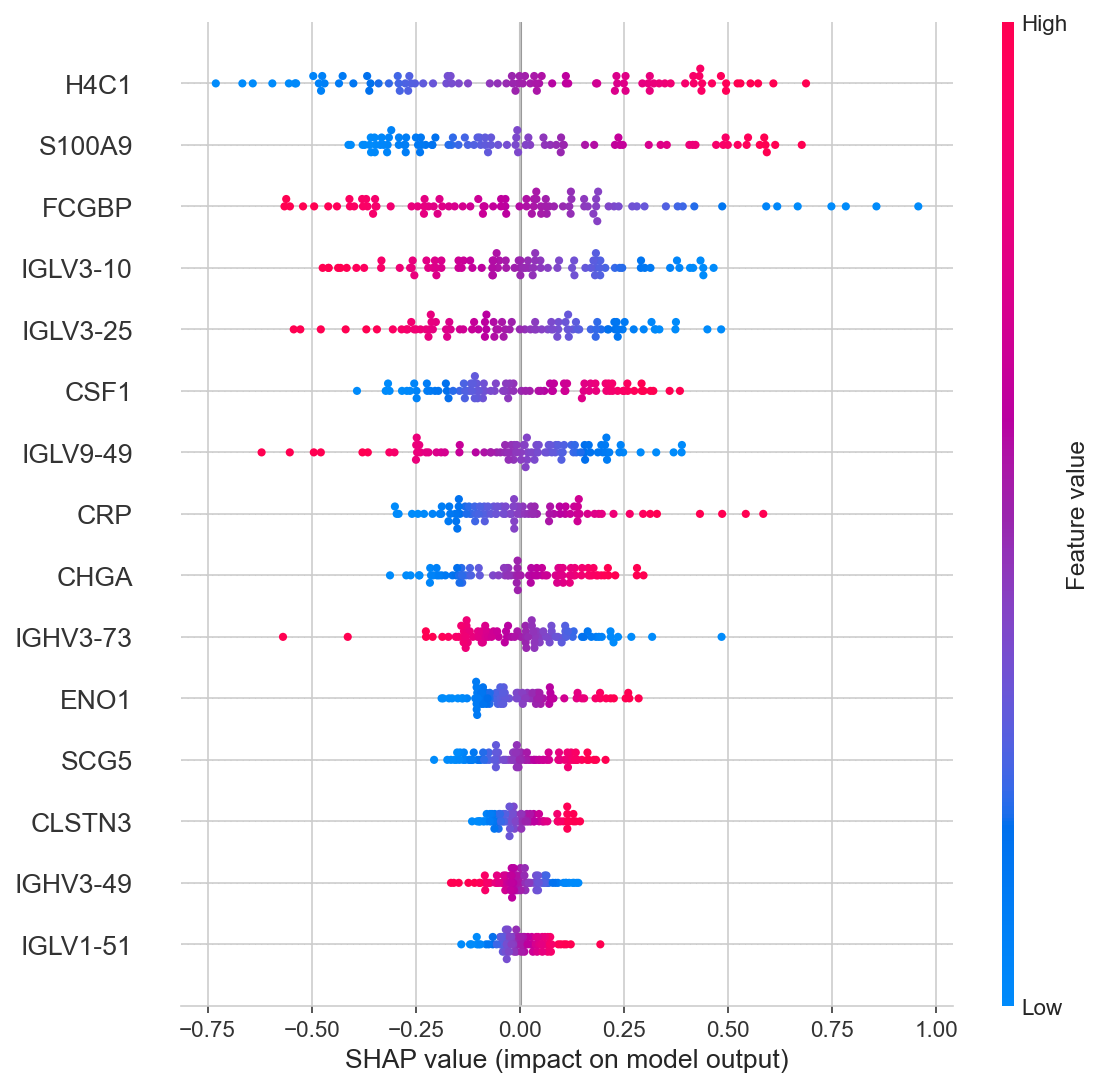

In [248]:
# shaply feature importance
import shap

X_train_df = pd.DataFrame(X_train, columns = topfeatures_identifiers)
X_test_df = pd.DataFrame(X_val, columns = topfeatures_identifiers)

# Generate the Tree SHAP estimator of Shapley values that corresponds to the LDA we built
explainer = shap.LinearExplainer(optimal_models[0], X_train_df)
# Compute the estimated Shapley values for the test sample's observations
shap_values = explainer.shap_values(X_train_df)

plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, X_train_df,max_display=17,show=False)

plt.savefig('../submission/f2b.svg', format = 'svg') #.png,.pdf will also support here

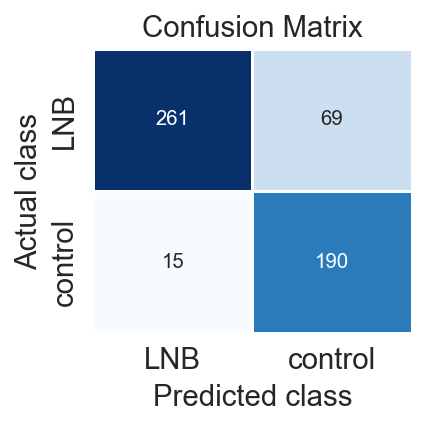

In [249]:
y_true = result[(result.model==name)&(result.run=='val')].observed
y_pred = result[(result.model==name)&(result.run=='val')].predicted
confusion_m = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(3,3))
s = sns.heatmap(confusion_m, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues",
           xticklabels=['LNB','control'], yticklabels=['LNB','control'])
s.set(xlabel="Predicted class", ylabel='Actual class')
s.set(title = "Confusion Matrix")
fig.tight_layout()
#fig.savefig('/Users/tzx804/projects/collaborations/nicolai/misc/sepsis/output/test_confusion_pride.pdf')
# 


In [253]:
# Confusion matrix
tn, fp, fn, tp = confusion_m.ravel()

# Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Sensitivity (Recall)
sensitivity = tp / (tp+fn)

# Specificity
specificity = tn / (tn + fp)

# PPV (Precision) from sklearn
ppv = tp / (tp+fp)

# NPV 
npv = tn / (tn + fn)

print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity : {specificity:.3f}")
print(f"PPV (Precision): {ppv:.3f}")
print(f"NPV: {npv:.3f}")

Accuracy: 0.843
Sensitivity (Recall): 0.927
Specificity : 0.791
PPV (Precision): 0.734
NPV: 0.946


In [254]:
# UMAP
from umap import UMAP

# processed and imputed
features = topfeatures_identifiers
umap_2d = UMAP(n_components=2, init='random', random_state=0)

umap_df = pd.DataFrame(umap_2d.fit_transform(prepared_data[topfeatures_identifiers]))
fig = px.scatter(umap_df, x=0, y=1,
                 color=prepared_data.reset_index()['_diagnosis'],
                 template = 'simple_white', height = 400, width = 900, facet_col=prepared_data.reset_index()['_study'])
fig.show()
#    fig.write_image('../submission/csf_UMAP_VM_festures_{}.pdf'.format(col))


### ML: LNB vs. control

The strategy is the same

In [255]:
prepared_data = ml_data.copy()
prepared_data=zscore(prepared_data, axis = 1)
train_data = prepared_data.loc[(prepared_data.index.get_level_values('_study')=='csf_development')&(prepared_data.index.get_level_values('_diagnosis').isin(['LNB','control']))]

no_cv = 5
X = train_data.values # all the protein columns
sample_lst = train_data.index.get_level_values('_sample').values
y = pd.Categorical(train_data.index.get_level_values('_diagnosis')).codes # control is 0, LNB is 1 or LNB 0 and VM 1
#X_train, X_test, y_train, y_test, samples_train, samples_test = train_test_split(X, y, train_data['sample'].tolist(), test_size=0.2, random_state=7, stratify=y)
X_train = X.copy()
y_train = y.copy()
sum(y_train)


48

In [256]:
val_data = prepared_data.loc[(prepared_data.index.get_level_values('_study')=='csf_validation')&(prepared_data.index.get_level_values('_diagnosis').isin(['LNB','control']))]
X_val = val_data.values
y_val = pd.Categorical(val_data.index.get_level_values('_diagnosis')).codes
sum(y_val)

48

In [ ]:
from itertools import compress
protein_cols = gene_mapping_df.loc[combined_lst]['Gene Names'].tolist()
# ML alg. selection
optimal_models = []
optimal_no_features = []
optimal_features = []
start_time = time.time()

dfs = []
metrics = []
to_plot = []   
fitted_models = []
    
for name, grid, estimator in models:
    print(name)
    # grid search
    selector = RandomizedSearchCV(estimator=estimator, param_distributions=grid, cv=StratifiedKFold(no_cv), scoring = 'f1_weighted', n_jobs = -1)
    clf = selector.fit(X_train,y_train)
    optimal_model = clf.best_estimator_
    optimal_models.append(optimal_model)
    # feature reduction
    if name in ['Naive Bayes','NNet', 'GP', 'QDA', 'KNN']: # skip rfecv for models not supported by importance
        optimal_no_features.append(len(protein_cols))
        optimal_features.append(protein_cols)
        print('skipping feature importance')
        X_reduced = X_train
        X_val_reduced = X_val
    else:
        selector = RFECV(optimal_model, cv=5, scoring='f1_weighted')
        selector = selector.fit(X_train, y_train)
        optimal_no_features.append(sum(selector.support_))
        optimal_features.append(list(compress(protein_cols, selector.support_)))
        print('optimal no features = {}'.format(sum(selector.support_)))
        X_reduced = X_train[:,selector.support_]
        X_val_reduced = X_val[:, selector.support_]
    
    # compute cv results
    print('computing predictions for: {}'.format(name))
    classifier = optimal_model
    mccs = []
    aucs = []
    fits = []
    mcc_val = []
    auc_val = []
                            
    # calculate performance during training
    cv = StratifiedKFold(n_splits=no_cv)
    for i, (train, test) in enumerate(cv.split(X_reduced, y_train)):
        print('cv: {}'.format(i+1))
        classifier.fit(X_reduced[train], y_train[train])
        
        fits.append(classifier)
        # predict for "test" set
        y_pred = classifier.predict(X_reduced[test])
        y_prob = classifier.predict_proba(X_reduced[test])[:,1]
        result = pd.DataFrame([y_train[test], y_pred, y_prob]).T
        result.columns = ['observed','predicted','probability']
        result['cv']=i+1
        result['model']=name
        result['sample']=sample_lst[test]
        result['run']='test'
        dfs.append(result)
        mccs.append(round(matthews_corrcoef(result.observed, result.predicted),2))
        aucs.append(round(roc_auc_score(result.observed,result.probability),2))
        # predict for validation sets
        y_pred = classifier.predict(X_val_reduced)
        y_prob = classifier.predict_proba(X_val_reduced)[:,1]
        result = pd.DataFrame([y_val, y_pred, y_prob]).T
        result.columns = ['observed','predicted','probability']
        result['cv']=i+1
        result['model']=name
        result['sample']=val_data.index.get_level_values('_sample').tolist()
        result['run']='val'
        dfs.append(result)  
        mcc_val.append(round(matthews_corrcoef(result.observed, result.predicted),2))
        auc_val.append(round(roc_auc_score(result.observed,result.probability),2))      
        
    fitted_models.append(fits)
    #test
    metrics_results = pd.DataFrame(mccs)
    metrics_results.columns = ['MCC']
    metrics_results['AUROC']=aucs
    metrics_results['cv']=list(range(1,1+no_cv))
    metrics_results['model']=name
    metrics_results['run']='test'
    metrics.append(metrics_results)

    #val
    metrics_results = pd.DataFrame(mccs)
    metrics_results.columns = ['MCC']
    metrics_results['AUROC']=aucs
    metrics_results['cv']=list(range(1,1+no_cv))
    metrics_results['model']=name
    metrics_results['run']='val'
    metrics.append(metrics_results)
    
    mcc_mean = np.mean(mccs)
    mcc_std = np.std(mccs)
    auroc_mean = np.mean(aucs)
    auroc_std = np.std(aucs)
    to_plot.append([name, mcc_mean, mcc_std, auroc_mean, auroc_std])
    print('MCC: {}, AUROC: {}'.format(mcc_mean, auroc_mean))
    
    print('\n{} model tested --- {} minutes ---\n'.format(name,round(((time.time() - start_time)/60),3)))


result_df = pd.concat(dfs)
metrics_df = pd.concat(metrics)


LR


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Use

optimal no features = 5
computing predictions for: LR
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.736, AUROC: 0.9259999999999999

LR model tested --- 0.029 minutes ---

LDA


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.

/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


8 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estima

optimal no features = 42
computing predictions for: LDA
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.72, AUROC: 0.908

LDA model tested --- 0.037 minutes ---

KNN
skipping feature importance
computing predictions for: KNN
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.6739999999999999, AUROC: 0.8379999999999999

KNN model tested --- 0.039 minutes ---

DT


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
  

optimal no features = 18
computing predictions for: DT
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.538, AUROC: 0.778

DT model tested --- 0.044 minutes ---

Naive Bayes
skipping feature importance
computing predictions for: Naive Bayes
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.698, AUROC: 0.884

Naive Bayes model tested --- 0.045 minutes ---

SVC


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.

/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



optimal no features = 9
computing predictions for: SVC
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
MCC: 0.76, AUROC: 0.952

SVC model tested --- 0.053 minutes ---

RF


/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/annelaura/projects/poetry/alphastats-project/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Users/annelaura/projects/poetry/alphastats-pr

In [ ]:
plot_df = pd.DataFrame(to_plot)
plot_df.columns=['model','mcc_mean','mcc_std','auroc_mean','auroc_std']
plot_df = round(plot_df,2)
plot_df['no_features']=[len(x) for x in optimal_features]
plot_df['features']=optimal_features
plot_df = plot_df.sort_values('auroc_mean').reset_index(drop = True)
plot_df['model_n_features']= ['{} (no. proteins = {})'.format(plot_df.loc[i,'model'],plot_df.loc[i,'no_features']) for i in plot_df.index.tolist()]



In [ ]:
from plotly.subplots import make_subplots
butterfly_plot(plot_df, var1 = 'mcc_mean', var2 = 'auroc_mean', var3 = 'no_features', error1 = 'mcc_std', error2 = 'auroc_std', name = 's5', savesvg=True, group = 'model_n_features')


In [ ]:
selector = RFECV(optimal_models[5], cv=5, scoring='f1_weighted')
selector = selector.fit(X_train, y_train)

print(f"Optimal number of features: {selector.n_features_}")


Optimal number of features: 9


In [ ]:
name = "SVC"
error_max = selector.cv_results_['mean_test_score']+selector.cv_results_['std_test_score']
error_min = selector.cv_results_['mean_test_score']-selector.cv_results_['std_test_score']

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.concatenate([list(range(1,len(protein_cols)+1)),list(range(1,len(protein_cols)+1))[::-1]]),
    y=np.concatenate([error_max, error_min[::-1]]),
    fill='toself', opacity=0.5, name = '1 std.'))
fig.add_trace(go.Scatter(x=list(range(1,len(protein_cols)+1)), y = selector.cv_results_['mean_test_score'],
                         name='Mean test score',line = dict(color='firebrick', width=1)))
fig.add_trace(go.Scatter(x = [selector.n_features_,selector.n_features_], name = 'Optimal number of features: {}'.format(selector.n_features_), 
                         y=[0,1], 
                         mode='lines', 
                         line=dict(color='green', width=2, dash='dash')))

fig.update_layout(template='simple_white',
    autosize=False,
    width=800,
    height=500,
    title="RFECV for {} classifier".format(name),
    xaxis_title="Number of features selected",
    yaxis_title="F1-weighted",
    legend_title="",
    #legend=dict(y=1.1, orientation='h'),
    legend_traceorder="reversed",
    xaxis_range=[0,46],
    yaxis_range = [0,max(error_max)])

#fig.write_image('../submission/RFECV_{}.pdf'.format(name))
fig.show()

In [ ]:
topfeatures_identifiers = list(compress(protein_cols, selector.support_))

In [ ]:
X_train = zscore(X_train[:, selector.support_], axis = 1)
X_val = zscore(X_val[:, selector.support_], axis = 1)


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# compute cv results
print('computing predictions for: {}'.format(optimal_models[5]))
classifier = optimal_models[5]
name = 'SVC'
mccs = []
aucs = []
fits = []
mcc_val = []
auc_val = []
dfs = []
                        
# calculate performance during training 
cv = StratifiedKFold(n_splits=no_cv)
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    print('cv: {}'.format(i+1))
    classifier.fit(X_train[train], y_train[train])
    #calibrated = CalibratedClassifierCV(classifier, method='sigmoid', cv=5)
    #calibrated.fit(X_train[train], y_train[train])
    #classifier = calibrated
    fits.append(classifier)
    # predict for "test" set
    y_pred = classifier.predict(X_train[test])
    y_prob = classifier.predict_proba(X_train[test])[:,1]
    result = pd.DataFrame([y_train[test], y_pred, y_prob]).T
    result.columns = ['observed','predicted','probability']
    result['cv']=i+1
    result['model']=name
    result['sample']=sample_lst[test]
    result['run']='test'
    dfs.append(result)
    mccs.append(round(matthews_corrcoef(result.observed, result.predicted),2))
    aucs.append(round(roc_auc_score(result.observed,result.probability),2))
    # predict for validation sets
    y_pred = classifier.predict(X_val)
    y_prob = classifier.predict_proba(X_val)[:,1]
    result = pd.DataFrame([y_val, y_pred, y_prob]).T
    result.columns = ['observed','predicted','probability']
    result['cv']=i+1
    result['model']=name
    result['sample']=val_data.index.get_level_values('_sample').tolist()
    result['run']='val'
    dfs.append(result)  
    mcc_val.append(round(matthews_corrcoef(result.observed, result.predicted),2))
    auc_val.append(round(roc_auc_score(result.observed,result.probability),2))      
    
mcc_mean = np.mean(mccs)
mcc_std = np.std(mccs)
auroc_mean = np.mean(aucs)
auroc_std = np.std(aucs)
to_plot.append([name, mcc_mean, mcc_std, auroc_mean, auroc_std])
print('Test: MCC: {}, AUROC: {}'.format(mcc_mean, auroc_mean))
print('Validation: MCC: {}, AUROC: {}'.format(np.mean(mcc_val), np.mean(auc_val)))

result = pd.concat(dfs)


computing predictions for: SVC(class_weight='balanced', kernel='linear', probability=True, random_state=7)
cv: 1
cv: 2
cv: 3
cv: 4
cv: 5
Test: MCC: 0.7220000000000001, AUROC: 0.946
Validation: MCC: 0.692, AUROC: 0.9259999999999999


In [ ]:
name = "SVC"

fig = go.Figure()
# ROC for TEST
test_data = roc_data(result, model = name, run = "test")
# output_order = test_data[0], test_data[1], test_data[2], test_data[3], test_data[4], auc_sd, ci_upper, ci_lower, mcc_mean, mcc_std
fig.add_trace(go.Scatter(
    x=np.concatenate([test_data[0],test_data[0][::-1]]),
    y=np.concatenate([test_data[2], test_data[3][::-1]]),
    fill='toself', opacity=0.5, name = 'std.'))
print('TEST auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]))
fig.add_trace(go.Scatter(x = test_data[0], name = 'TEST auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]), 
                         y=test_data[1], 
                         mode='lines', 
                         line=dict(color='grey', width=2, dash='dash')))
test_data = roc_data(result, model = name, run = "val")
print('VAL auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]))
fig.add_trace(go.Scatter(x = test_data[0], name = 'VAL auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]), 
                         y=test_data[1], 
                         mode='lines', 
                         line=dict(color='green', width=2)))

fig.update_layout(template='simple_white',
    autosize=False,
    width=1000,
    height=500,
    title="AUROC for SVC classifier",
    xaxis_title="TPR",
    yaxis_title="FPR",
    legend_title="",
    legend_traceorder="reversed",
    xaxis_range=[0,1],
    yaxis_range = [0,1])
fig.write_image('../submission/f2c.svg', width = 950)

fig.show()

TEST auc = 94.67 (std. = 4.3, ci = 100.63-88.7), mcc = 0.7198 (std. = 0.1525))
VAL auc = 92.64 (std. = 1.99, ci = 95.4-89.88), mcc = 0.6927 (std. = 0.0631))


/var/folders/jd/85bcy5y934xgmfylqnhhpwrm0000gn/T/ipykernel_66984/1238792451.py:25: DeprecationWarning:

Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.

/var/folders/jd/85bcy5y934xgmfylqnhhpwrm0000gn/T/ipykernel_66984/1238792451.py:25: DeprecationWarning:

Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.



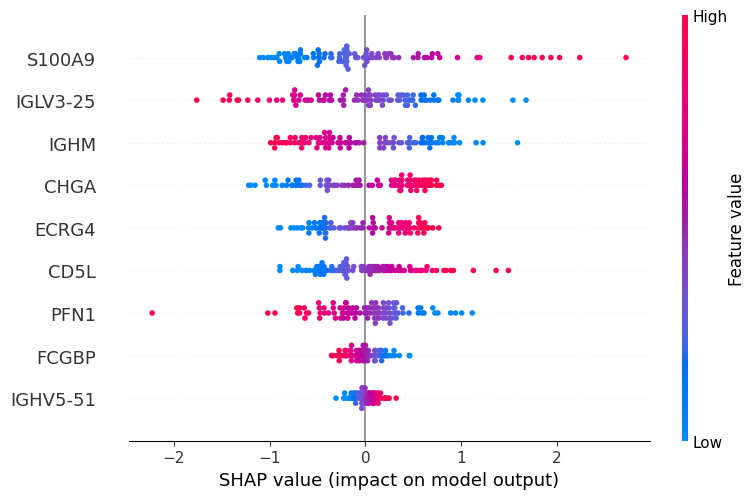

In [ ]:
# shaply feature importance
import shap

X_train_df = pd.DataFrame(X_train, columns = topfeatures_identifiers)
#X_test_df = pd.DataFrame(X_val, columns = topfeatures_identifiers)

# Generate the Tree SHAP estimator of Shapley values that corresponds to the LDA we built
explainer = shap.LinearExplainer(optimal_models[5], X_train_df)
# Compute the estimated Shapley values for the test sample's observations
shap_values = explainer.shap_values(X_train_df)

plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, X_train_df,max_display=17,show=False)

plt.savefig('../submission/f2d.svg', format = 'svg') #.png,.pdf will also support here

plt.show()


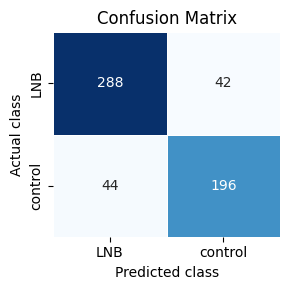

In [ ]:
y_true = result[(result.model==name)&(result.run=='val')].observed
y_pred = result[(result.model==name)&(result.run=='val')].predicted
confusion_m = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(3,3))
s = sns.heatmap(confusion_m, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues",
           xticklabels=['LNB','control'], yticklabels=['LNB','control'])
s.set(xlabel="Predicted class", ylabel='Actual class')
s.set(title = "Confusion Matrix")
fig.tight_layout()
#fig.savefig('/Users/tzx804/projects/collaborations/nicolai/misc/sepsis/output/test_confusion_pride.pdf')
# 


In [ ]:
# Confusion matrix
tn, fp, fn, tp = confusion_m.ravel()

# Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Sensitivity (Recall)
sensitivity = tp / (tp+fn)

# Specificity
specificity = tn / (tn + fp)

# PPV (Precision) from sklearn
ppv = tp / (tp+fp)

# NPV 
npv = tn / (tn + fn)

print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity : {specificity:.3f}")
print(f"PPV (Precision): {ppv:.3f}")
print(f"NPV: {npv:.3f}")

Accuracy: 0.849
Sensitivity (Recall): 0.817
Specificity: 0.873


In [ ]:
# UMAP
from umap import UMAP

# processed and imputed
features = topfeatures_identifiers
umap_2d = UMAP(n_components=2, init='random', random_state=0)

umap_df = pd.DataFrame(umap_2d.fit_transform(prepared_data[topfeatures_identifiers]))
fig = px.scatter(umap_df, x=0, y=1,
                 color=prepared_data.reset_index()['_diagnosis'],
                 template = 'simple_white', height = 400, width = 900, facet_col=prepared_data.reset_index()['_study'])
fig.show()
#    fig.write_image('../submission/csf_UMAP_VM_festures_{}.pdf'.format(col))
